In [1]:
import pandas as pd
import numpy as np

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sqlalchemy import create_engine

In [3]:
import datetime as dt

# Data Pre-Processing

In [4]:
engine = create_engine("sqlite:///../db/twitter_db.sqlite")
conn = engine.connect()

In [5]:
tweets_df = pd.read_sql("SELECT * FROM tweet_data", conn)

In [6]:
tweets_df.head(2)

,id,created_at,created_at_time,created_at_date,created_at_datetime,tweet_id,tweet_id_str,full_text,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user_id,user_id_str,user_name,user_screen_name,retweet_count,favorite_count
0,1,Wed Jul 31 22:21:23 +0000 2019,22:21:23.000000,2019-07-31,2019-07-31 22:21:23.000000,1156691352983412737,1156691352983412737,"Here's the deal, President Trump inherited the...",NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,938,4134
1,2,Wed Jul 31 21:28:00 +0000 2019,21:28:00.000000,2019-07-31,2019-07-31 21:28:00.000000,1156677917469896704,1156677917469896704,I’ve got some exciting news: I am now on Snapc...,NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,173,790


In [7]:
len(tweets_df)

41891

In [8]:
tweets_df["created_at_datetime"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strptime(x,
                                                                "%Y-%m-%d %H:%M:%S.%f"))

In [9]:
tweets_df = tweets_df.loc[tweets_df["created_at_datetime"] < dt.datetime(2019,8,15), :].reset_index(drop=True)

In [10]:
len(tweets_df)

40678

In [11]:
grouped_df = tweets_df.groupby(tweets_df['user_name']).median()
grouped_df = grouped_df[['retweet_count']].sort_values('retweet_count', ascending = False).iloc[:7]
# grouped_df.sort_values('retweet_count', ascendingh = False)
grouped_df
top_candidates =[]
for i, r in grouped_df.iterrows():
    top_candidates.append(i)
# Remove Eric Swalwell from list (dropped out)
top_candidates.pop(3)
top_candidates

['Donald J. Trump',
 'Bernie Sanders',
 'Kamala Harris',
 'Elizabeth Warren',
 'Joe Biden',
 'Tulsi Gabbard']

In [12]:
tweets_df = tweets_df.loc[tweets_df['user_name'].isin(top_candidates), :].reset_index(drop=True)

In [13]:
len(tweets_df)

10520

In [14]:
tweets_df["day"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%A"))
tweets_df["hour"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%H"))
tweets_df["month"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%B"))

In [15]:
tweets_df.drop(columns = ["created_at", "created_at_time", "created_at_date","created_at_datetime",
                    "tweet_id", "tweet_id_str", "in_reply_to_status_id",
                    "in_reply_to_status_id_str", "in_reply_to_user_id",
                    "in_reply_to_user_id_str", "in_reply_to_screen_name",
                    "user_id_str", "user_id", "user_screen_name", "id"], inplace = True)

In [16]:
tweets_df = tweets_df[["user_name", "month", "day", "hour", "retweet_count", "favorite_count", "full_text"]]

In [17]:
tweets_df.head(2)

,user_name,month,day,hour,retweet_count,favorite_count,full_text
0,Joe Biden,July,Wednesday,22,938,4134,"Here's the deal, President Trump inherited the..."
1,Joe Biden,July,Wednesday,21,173,790,I’ve got some exciting news: I am now on Snapc...


In [18]:
len(tweets_df.groupby(tweets_df["user_name"]).count())

6

In [19]:
X_count_df = tweets_df[["full_text", "month", "day", "hour", "retweet_count", "favorite_count"]]
X_count_df = pd.get_dummies(X_count_df, columns = ["month", "day", "hour"])

In [20]:
X_count_df.head(2)

,full_text,retweet_count,favorite_count,month_April,month_August,month_December,month_February,month_January,month_July,month_June,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,"Here's the deal, President Trump inherited the...",938,4134,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,I’ve got some exciting news: I am now on Snapc...,173,790,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
import nltk
import re
import string
pd.set_option('display.max_colwidth', 100) # To extend column width

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

In [22]:
def clean_text(text):
    text = text.replace('&amp;', '&')
    text = text.replace('\n', ' ')
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# Bag of Words

# Count Vectorizer

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer
count_vect = CountVectorizer(analyzer=clean_text)
X_count_vect = count_vect.fit_transform(X_count_df['full_text'])

In [24]:
X_count_df.drop(columns = ['full_text'], inplace = True)

In [25]:
X_count_df = pd.concat([X_count_df, pd.DataFrame(X_count_vect.toarray(), columns=count_vect.get_feature_names())], axis=1)

In [26]:
X_count_df.shape

(10520, 20445)

In [27]:
data_y = tweets_df.values
data_x = X_count_df.values
X_count = data_x[:, 0:]
y_count = data_y[:,0]

In [29]:
X_count

array([[  938,  4134,     0, ...,     0,     0,     0],
       [  173,   790,     0, ...,     0,     0,     0],
       [  712,  4376,     0, ...,     0,     0,     0],
       ...,
       [  741, 20234,     0, ...,     0,     0,     0],
       [18289, 68718,     0, ...,     0,     0,     0],
       [   11,    74,     0, ...,     0,     0,     0]], dtype=int64)

In [39]:
X_count.shape

(10520, 20445)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from keras.utils import to_categorical

## Train-Test-Split/One-Hot-Encoding (Grid Search)

In [75]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_count, y_count, random_state=42,
                                                               train_size = 0.9,
                                                               shuffle = True)

In [77]:
X_scaler_cv = MinMaxScaler().fit(X_train_cv)

C:\Users\lande\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [78]:
X_train_scaled_cv = X_scaler_cv.transform(X_train_cv)
X_test_scaled_cv = X_scaler_cv.transform(X_test_cv)

In [79]:
# Step 1: Label-encode data set
label_encoder_cv = LabelEncoder()
label_encoder_cv.fit(y_train_cv)

encoded_y_train_cv = label_encoder_cv.transform(y_train_cv)
encoded_y_test_cv = label_encoder_cv.transform(y_test_cv)

In [80]:
# Step 2: One-hot encoding
y_train_categorical_cv = to_categorical(encoded_y_train_cv)
y_test_categorical_cv = to_categorical(encoded_y_test_cv)

## Train-Test-Split/One-Hot-Encoding (In-Depth Paramater Tuning)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_count, y_count, random_state=42)

In [33]:
X_scaler = MinMaxScaler().fit(X_train)

C:\Users\lande\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [40]:
X_train_scaled.shape

(7890, 20445)

In [35]:
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [36]:
# Step 2: One-hot encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

Using TensorFlow backend.


In [41]:
y_train_categorical.shape

(7890, 6)

## GridSearch (Count Vectorizer)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [81]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1, verbose = 3)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_train_scaled_cv, y_train_categorical_cv)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 56.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
10,496.646349,29.953306,3.174986,1.193737,None,150,"{'max_depth': None, 'n_estimators': 150}",0.441394,0.429250,0.439282,...,0.441593,0.007444,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
11,756.527510,11.736612,3.103303,0.225261,None,300,"{'max_depth': None, 'n_estimators': 300}",0.433474,0.433474,0.434002,...,0.437262,0.005353,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,53.534277,7.797790,0.851523,0.101199,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.407075,0.408659,0.433474,...,0.421631,0.012687,3,0.817666,0.792844,0.818854,0.798152,0.809769,0.807457,0.010388
9,119.023888,42.473363,1.673524,0.929464,None,10,"{'max_depth': None, 'n_estimators': 10}",0.439810,0.400211,0.398627,...,0.416350,0.017481,4,0.948904,0.944283,0.948640,0.947195,0.949439,0.947692,0.001859
7,408.392349,102.002355,4.380501,3.220087,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.384900,0.364836,0.371700,...,0.378010,0.010721,5,0.860708,0.855030,0.861764,0.871419,0.861914,0.862167,0.005270


## In-Depth Parameter Tuning

## N-Estimators (Count Vectorizer)

In [49]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300]

train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_scaled, y_train_categorical)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled, y_train_categorical))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled, y_test_categorical))

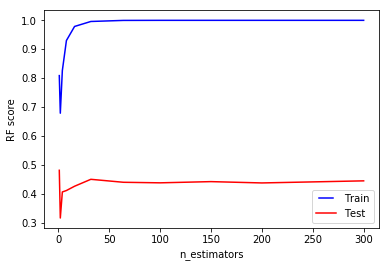

In [51]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
#Best ~ 20

## Max-Depth (Count Vectorizer)

In [55]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [52]:
max_depths = np.linspace(1, 90, 90, endpoint=True)

In [53]:
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_scaled, y_train_categorical)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled, y_train_categorical))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled, y_test_categorical))

C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

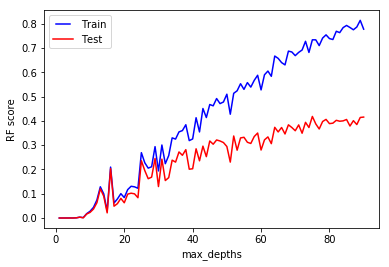

In [54]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_depths')
plt.show()

In [ ]:
# Best ~ 30

## Min_samples_split (Count Vectorizer)

In [58]:
min_samples_splits = list(np.linspace(0.1, 1.0, 10, endpoint=True))

In [59]:
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
    rf.fit(X_train_scaled, y_train_categorical)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled, y_train_categorical))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled, y_test_categorical))

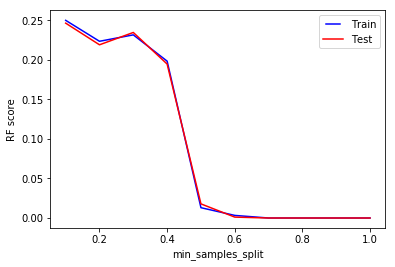

In [60]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_split')
plt.show()

In [ ]:
# Best ~ 2

## Min_samples_leaf (Count Vectorizer)

In [61]:
min_samples_leafs = list(np.linspace(0.1, 0.5, 5, endpoint = True))

In [62]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled, y_train_categorical)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled, y_train_categorical))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled, y_test_categorical))

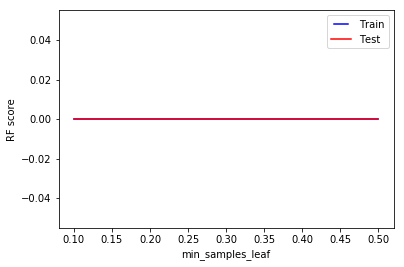

In [65]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_leaf')
plt.show()

In [ ]:
#Best ~ 1

## Max_Features (Count Vectorizer)

In [86]:
max_features_list = list(range(1, 3000, 100))
# max_features_list

In [87]:
train_results = []
test_results = []
for max_features in max_features_list:
    rf = RandomForestClassifier(max_features=max_features, n_jobs=-1)
    rf.fit(X_train_scaled, y_train_categorical)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled, y_train_categorical))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled, y_test_categorical))

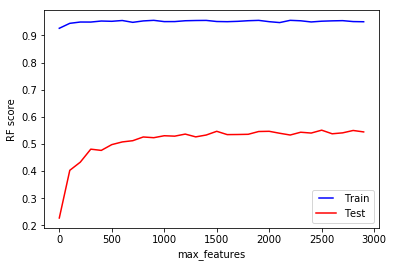

In [88]:
line1, = plt.plot(max_features_list, train_results, 'b', label="Train")
line2, = plt.plot(max_features_list, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_features')
plt.show()

In [ ]:
# Best ~ 1500

## In-Depth Parameter Tuning Scoring (Count Vectorizer)

In [90]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=20, max_depth=30, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 1500)
rf = rf.fit(X_train_scaled, y_train_categorical)
rf.score(X_test_scaled, y_test_categorical)

0.4300380228136882

# TF-IDF Vectorizer

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [92]:
X_tdidf_df = tweets_df[["full_text", "month", "day", "hour", "retweet_count", "favorite_count"]]
X_tdidf_df = pd.get_dummies(X_tdidf_df, columns = ["month", "day", "hour"])

In [93]:
# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf_vect = tfidf_vect.fit_transform(X_tdidf_df['full_text'])

In [94]:
X_tdidf_df.drop(columns = ['full_text'], inplace = True)

In [95]:
X_tdidf_df = pd.concat([X_tdidf_df, pd.DataFrame(X_tfidf_vect.toarray(), columns=tfidf_vect.get_feature_names())], axis=1)

In [96]:
X_tdidf_df.shape

(10520, 20445)

In [98]:
data_y_idf = tweets_df.values
data_x_idf = X_tdidf_df.values
X_count_idf = data_x[:, 0:]
y_count_idf = data_y[:,0]

## Train-Test-Split/One-Hot-Encoding (In-Depth Parameter Tuning)

In [99]:
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(X_count_idf, y_count_idf, random_state=42,
                                                                   shuffle = True)

In [100]:
X_scaler_idf = MinMaxScaler().fit(X_train_idf)

In [101]:
X_train_scaled_idf = X_scaler_idf.transform(X_train_idf)
X_test_scaled_idf = X_scaler_idf.transform(X_test_idf)

In [102]:
# Step 1: Label-encode data set
label_encoder_idf = LabelEncoder()
label_encoder_idf.fit(y_train_idf)

encoded_y_train_idf = label_encoder_idf.transform(y_train_idf)
encoded_y_test_idf = label_encoder_idf.transform(y_test_idf)

In [103]:
# Step 2: One-hot encoding
y_train_categorical_idf = to_categorical(encoded_y_train_idf)
y_test_categorical_idf = to_categorical(encoded_y_test_idf)

## In-Depth Parameter Tuning

## N-Estimators (TF-IDF Vectorizer)

In [104]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300]

train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_scaled_idf, y_train_categorical_idf)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled_idf, y_train_categorical_idf))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled_idf, y_test_categorical_idf))

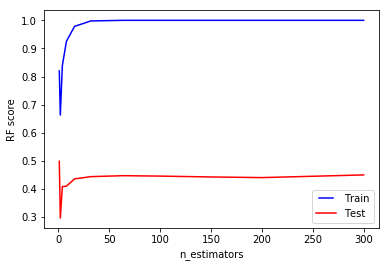

In [106]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
# Best: n-estimators=20

## Max-Depth (TF-IDF Vectorizer)

In [107]:
max_depths = list(np.linspace(1, 90, 90, endpoint=True))

In [108]:
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_scaled_idf, y_train_categorical_idf)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled_idf, y_train_categorical_idf))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled_idf, y_test_categorical_idf))

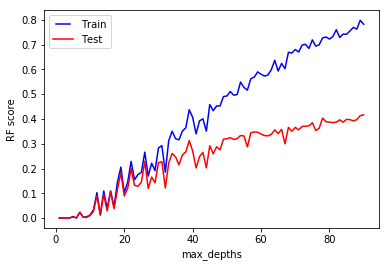

In [109]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_depths')
plt.show()

In [ ]:
#Best: max_depth=25

## Min_samples_split (TF-IDF Vectorizer)

In [110]:
min_samples_splits = list(np.linspace(0.1, 1.0, 10, endpoint=True))

In [111]:
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
    rf.fit(X_train_scaled_idf, y_train_categorical_idf)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled_idf, y_train_categorical_idf))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled_idf, y_test_categorical_idf))

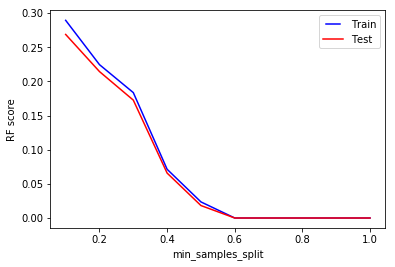

In [112]:
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_split')
plt.show()

In [ ]:
# Best: min_samples_split=2

## Min_samples_leaf (TF-IDF Vectorizer)

In [113]:
min_samples_leafs = list(np.linspace(0.1, 0.5, 5, endpoint = True))

In [114]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rf.fit(X_train_scaled_idf, y_train_categorical_idf)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled_idf, y_train_categorical_idf))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled_idf, y_test_categorical_idf))

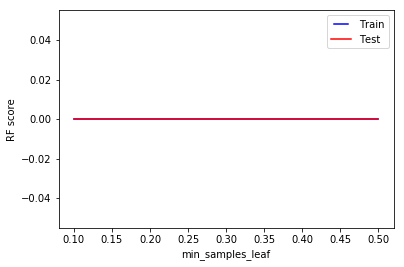

In [115]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('min_samples_leaf')
plt.show()

In [ ]:
#Best: min_samples_leaf = 1

## Max_Features (TF-IDF Vectorizer)

In [116]:
max_features_list = list(range(1, 3000, 100))

In [117]:
train_results = []
test_results = []
for max_features in max_features_list:
    rf = RandomForestClassifier(max_features=max_features, n_jobs=-1)
    rf.fit(X_train_scaled_idf, y_train_categorical_idf)

#     train_pred = rf.predict(X_train_scaled)

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)

    train_results.append(rf.score(X_train_scaled_idf, y_train_categorical_idf))

#     y_pred = rf.predict(x_test)


#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(rf.score(X_test_scaled_idf, y_test_categorical_idf))

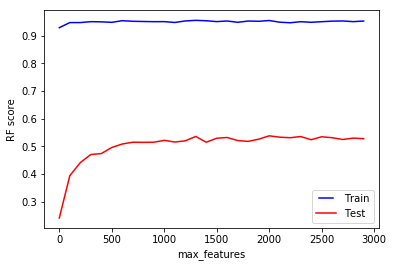

In [118]:
line1, = plt.plot(max_features_list, train_results, 'b', label="Train")
line2, = plt.plot(max_features_list, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_features')
plt.show()

In [ ]:
#Best: max_features=1500

## In-Depth Parameter Tuning Scoring (TF-IDF Vectorizer)

In [119]:
# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=20, max_depth=25, min_samples_split = 2,
                           min_samples_leaf = 1, max_features = 1500)
rf = rf.fit(X_train_scaled_idf, y_train_categorical_idf)
rf.score(X_test_scaled_idf, y_test_categorical_idf)

0.41634980988593157

In [39]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None],
        }

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_tdidf_df, tweets_df['user_name'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

C:\Users\lande\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lande\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,138.122783,4.958950,2.618398,0.639628,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.608923,0.549169,0.573942,...,0.587833,0.030188,1,0.973731,0.971361,0.972318,0.970298,0.969589,0.971459,0.001467
7,172.688825,8.645928,3.026706,0.593666,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.606550,0.537292,0.582501,...,0.585646,0.030537,2,0.993225,0.992632,0.993109,0.992872,0.990259,0.992419,0.001099
5,206.100773,9.678352,6.023996,3.633669,60,300,"{'max_depth': 60, 'n_estimators': 300}",0.610346,0.541568,0.575369,...,0.584506,0.029152,3,0.975514,0.974213,0.970773,0.970892,0.968639,0.972006,0.002501
8,244.101300,24.340598,4.215130,1.547126,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.600380,0.529691,0.582977,...,0.580323,0.030414,4,0.993581,0.992513,0.992278,0.992515,0.990140,0.992206,0.001127
11,247.679510,29.237682,2.185556,0.770084,None,300,"{'max_depth': None, 'n_estimators': 300}",0.596108,0.521140,0.581550,...,0.576236,0.037537,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [72]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None],
        'min_samples_split': list(np.linspace(0.1, 1.0, 10, endpoint=True)),
        'min_samples_leaf': list(np.linspace(0.1, 0.5, 5, endpoint = True)),
        'max_features': range(1, 22000, 2045)
        }

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_tdidf_df, tweets_df['user_name'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

KeyboardInterrupt: 

In [40]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
abc = AdaBoostClassifier()


param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_tdidf_df, tweets_df['user_name'])
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

In [41]:
np.linspace(0.1, 0.5, 5, endpoint=True)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [44]:
list(np.linspace(0.1, 1.0, 10, endpoint=True))

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [71]:
for x in range(1, 22000, 2045):
    print(x)

1
2046
4091
6136
8181
10226
12271
14316
16361
18406
20451


In [62]:
for i in range(0, 10, 2):
    print(i)

0
2
4
6
8


In [65]:
help(range(1, 20460, 2046))

Help on range object:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(

In [57]:
20446 % 9

7